In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import awkward as ak
import numpy as np
import uproot
import sklearn as sk

In [52]:
class TrackAnalysisModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=6, out_features=30)
        self.layer_2 = torch.nn.Linear(in_features=30, out_features=30)
        self.layer_3 = torch.nn.Linear(in_features=30, out_features=30)
        
        self.layer_4 = torch.nn.Linear(in_features=30, out_features=1)
        self.relu = torch.nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

# Old Code 

In [25]:
f = uproot.open("trackingNtuple_0.root")["trackingNtuple/tree;3"]
df = f.arrays(library="pd")

In [26]:
temp = ak.argmax(df['trk_simTrkIdx'][0], keepdims=True, axis=-1, mask_identity=False)
DataFrameIds=[df["trk_simTrkIdx"][0][i][temp[i]][0] if temp[i]!=-1 else temp[i][0].astype(np.int32) for i in range(len(temp))]

In [27]:
Check = []
for i in range(len(DataFrameIds)):
    if ((DataFrameIds[i]>0 and df['sim_pt'][0][DataFrameIds[i]]>0.9 and abs(df['sim_eta'][0][DataFrameIds[i]])<2.4) or DataFrameIds[i]<0):
        Check.append(i)
DataFrameIds = [DataFrameIds[trk] for trk in Check]

In [28]:
d = {'truth':[], 'trk_dxy':[], 'trk_dz':[], 'trk_pt':[], 'trk_eta':[], 'trk_nChi2':[], 'trk_nPixel':[]}
DataBase = pd.DataFrame(d)
f = {'truth':[1], 'trk_dxy':[1], 'trk_dz':[1], 'trk_pt':[1], 'trk_eta':[1], 'trk_nChi2':[1], 'trk_nPixel':[1]}
count=0
for ev in range(len(df)):
    temp = ak.argmax(df['trk_simTrkIdx'][ev], keepdims=True, axis=-1, mask_identity=False)
    DataFrameIds=[df["trk_simTrkIdx"][ev][i][temp[i]][0] if temp[i]!=-1 else temp[i][0].astype(np.int32) for i in range(len(temp))]
    #print(DataFrameIds)
    #print(len(DataFrameIds))
    for i in range(len(DataFrameIds)):
        #print(i)
        if ((DataFrameIds[i]>0 and df['sim_pt'][ev][DataFrameIds[i]]>0.9 and abs(df['sim_eta'][ev][DataFrameIds[i]])<2.4) or DataFrameIds[i]<0):
            f = {'truth':[bool(DataFrameIds[i]+1)], 'trk_dxy':[df["trk_dxy"][ev][i]], 'trk_dz':[df["trk_dz"][ev][i]], 'trk_pt':[df["trk_pt"][ev][i]], 'trk_eta':[df["trk_eta"][ev][i]], 'trk_nChi2':[df["trk_nChi2"][ev][i]], 'trk_nPixel':[df["trk_nPixel"][ev][i]]}
            DataBase.loc[count]=f
            #print(ev, i, DataFrameIds[i], df["trk_dxy"][ev][i], df["trk_dz"][ev][i], df["trk_pt"][ev][i], df["trk_eta"][ev][i], df["trk_nChi2"][ev][i], df["trk_nPixel"][ev][i])
            count+=1

In [29]:
print(DataBase.shape[0])

6828


In [30]:
DataBase1=DataBase.sample(frac=1, ignore_index=True)
for el in DataBase1.columns:
    for i in range(DataBase1.shape[0]):
        DataBase1.loc[i, el]=DataBase1[el][i][0]
DataBase1

,truth,trk_dxy,trk_dz,trk_pt,trk_eta,trk_nChi2,trk_nPixel
0,True,-0.017795,-1.251105,1.065375,-2.080281,1.618974,7
1,True,0.007955,5.350815,1.822835,1.22319,1.585989,4
2,True,0.009331,3.091979,1.252059,-0.557107,0.587102,4
3,True,0.005675,-0.627211,3.604365,1.137913,0.456585,4
4,True,-0.002278,1.616609,2.136552,2.072747,0.247012,4
...,...,...,...,...,...,...,...
6823,True,0.003032,-2.070742,1.856264,1.68854,0.777518,4
6824,True,-0.078501,0.286363,3.229348,-0.601506,1.25212,4
6825,False,0.006244,6.977582,1.034808,-0.787684,16.323128,4
6826,True,0.005624,-4.347488,1.055188,1.978985,1.097423,6


In [31]:
TrData=DataBase1.loc[:int(0.8*DataBase1.shape[0])]
ValData=DataBase1.loc[int(0.8*DataBase1.shape[0]):]

In [32]:
visualizer1 = []
visualizer2 = []
for i in range(len(TrData['truth'])):
    if TrData['truth'][i]==True:
        visualizer1.append(TrData['trk_nPixel'][i])
    else :
        visualizer2.append(TrData['trk_nPixel'][i])


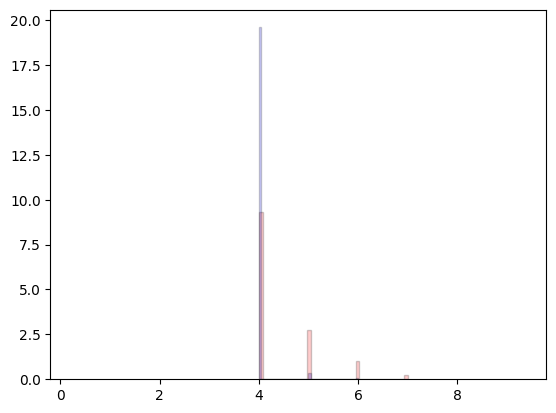

In [33]:
plt.xlim(-0.2, 9.8)
plt.hist(visualizer1, bins=40, color='red', alpha=0.2, density=True, ec="k")
plt.hist(visualizer2, bins=40, color='blue', alpha=0.2, density=True, ec="k")
plt.show()

In [34]:
data = np.zeros((TrData.shape[0], TrData.shape[1]-1))
target = np.zeros(TrData.shape[0])
for i in range(TrData.shape[0]):
    data[i, 0] = TrData['trk_dxy'][i]
    data[i, 1] = TrData['trk_dz'][i]
    data[i, 2] = TrData['trk_pt'][i]
    data[i, 3] = TrData['trk_eta'][i]
    data[i, 4] = TrData['trk_nChi2'][i]
    data[i, 5] = TrData['trk_nPixel'][i]
    target[i]  = TrData['truth'][i]

In [35]:
data1 = np.zeros((ValData.shape[0], ValData.shape[1]-1))
target1 = np.zeros(ValData.shape[0])
for i in range(ValData.shape[0]):
    data1[i, 0] = ValData['trk_dxy'][TrData.shape[0]+i-1]
    data1[i, 1] = ValData['trk_dz'][TrData.shape[0]+i-1]
    data1[i, 2] = ValData['trk_pt'][TrData.shape[0]+i-1]
    data1[i, 3] = ValData['trk_eta'][TrData.shape[0]+i-1]
    data1[i, 4] = ValData['trk_nChi2'][TrData.shape[0]+i-1]
    data1[i, 5] = ValData['trk_nPixel'][TrData.shape[0]+i-1]
    target1[i]  = ValData['truth'][TrData.shape[0]+i-1]

In [36]:
target = torch.from_numpy(target).type(torch.float)
data = torch.from_numpy(data).type(torch.float)

In [37]:
target1 = torch.from_numpy(target1).type(torch.float)
data1 = torch.from_numpy(data1).type(torch.float)

# New Part

In [38]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [40]:
model = TrackAnalysisModel().to(device)
print(model)

TrackAnalysisModel(
  (layer_1): Linear(in_features=6, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)


In [41]:
# Setup loss and optimizer 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [42]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
data, target = data.to(device), target.to(device)
data1, target1 = data1.to(device), target1.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(data).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, target) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=target, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(data1).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, target1)
      test_acc = accuracy_fn(y_true=target1,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70014, Accuracy: 88.98% | Test Loss: 0.67484, Test Accuracy: 88.07%
Epoch: 100 | Loss: 0.17676, Accuracy: 93.68% | Test Loss: 0.18648, Test Accuracy: 93.92%
Epoch: 200 | Loss: 0.16784, Accuracy: 94.16% | Test Loss: 0.17949, Test Accuracy: 94.51%
Epoch: 300 | Loss: 0.16422, Accuracy: 94.31% | Test Loss: 0.17645, Test Accuracy: 94.66%
Epoch: 400 | Loss: 0.16103, Accuracy: 94.34% | Test Loss: 0.17340, Test Accuracy: 94.51%
Epoch: 500 | Loss: 0.15773, Accuracy: 94.31% | Test Loss: 0.17050, Test Accuracy: 94.51%
Epoch: 600 | Loss: 0.15421, Accuracy: 94.36% | Test Loss: 0.16776, Test Accuracy: 94.58%
Epoch: 700 | Loss: 0.15072, Accuracy: 94.45% | Test Loss: 0.16514, Test Accuracy: 94.66%
Epoch: 800 | Loss: 0.14747, Accuracy: 94.56% | Test Loss: 0.16320, Test Accuracy: 94.58%
Epoch: 900 | Loss: 0.14430, Accuracy: 94.67% | Test Loss: 0.16097, Test Accuracy: 94.58%
Epoch: 1000 | Loss: 0.14077, Accuracy: 94.71% | Test Loss: 0.15839, Test Accuracy: 94.80%
Epoch: 1100 | Loss: 0.

In [43]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [50]:
PredVal = torch.round(torch.sigmoid(model(data1).squeeze()))
PredVal = PredVal.detach().numpy()
fpr, tpr, thr= sk.metrics.roc_curve(target1, PredVal, drop_intermediate=False)

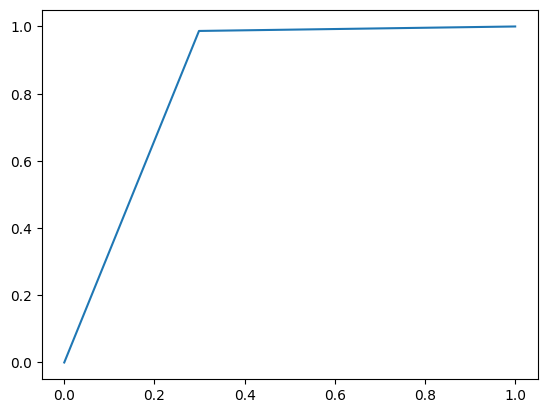

In [51]:
plt.plot(fpr, tpr)
plt.show()

In [74]:
ROCdata = np.column_stack([fpr, tpr])
np.savetxt("ROC_NN3x30.dat" , ROCdata)